# Traveling Salesman Computer Vision

**Kaggle Dataset**

https://www.kaggle.com/datasets/jeffheaton/traveling-salesman-computer-vision/data

In [131]:
# libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import tensorflow as tf

import PIL.Image as Image
import os
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [132]:
data_path = r"./tsp-all.csv"
train_data_path = r"./train.csv"

data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)

test_data_path = r"./test.csv"
test_data = pd.read_csv(test_data_path)

### Dataset Columns Description

The columns:

- **id**: A unique ID that allows linking across all three CSV files.
- **filename**: The name of each map's image file.
- **distance**: The total distance through the cities, this is the y/label.
- **key**: The generator filename, provides the dimensions, city count, & distance.

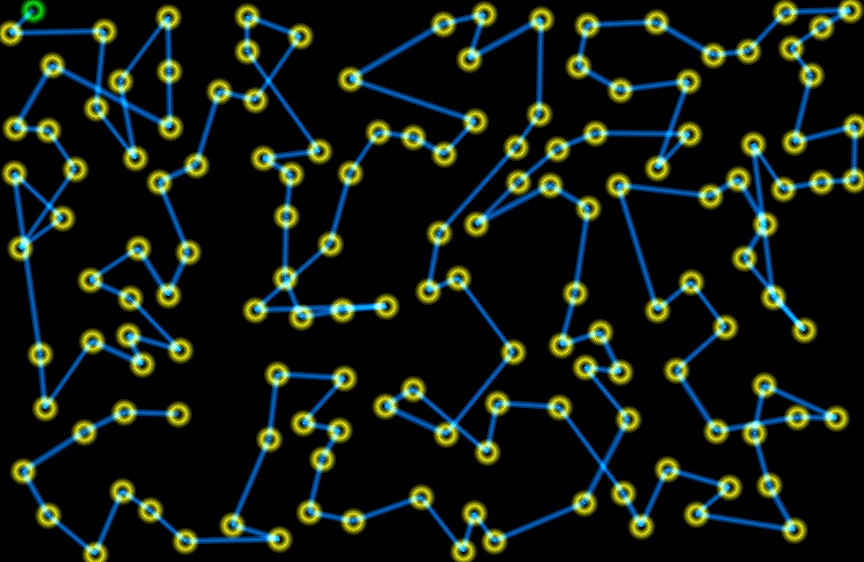

In [133]:
img_path = "./tsp-cv/16109.jpg"
img = Image.open(img_path)
img

In [134]:
data = pd.DataFrame(data)
data

,id,filename,distance,key
0,0,0.jpg,83110,503x673-270-83110.jpg
1,1,1.jpg,1035,906x222-10-1035.jpg
2,2,2.jpg,20756,810x999-299-20756.jpg
3,3,3.jpg,13286,781x717-272-13286.jpg
4,4,4.jpg,13924,609x884-312-13924.jpg
...,...,...,...,...
20018,20019,20019.jpg,7146,376x499-257-7146.jpg
20019,20020,20020.jpg,9695,403x543-348-9695.jpg
20020,20021,20021.jpg,11420,678x497-398-11420.jpg
20021,20022,20022.jpg,15570,739x605-45-15570.jpg


In [135]:
width,height,city_count = [],[],[]
def extract_info(key):
    numbers = re.findall(r'\d+', key) # Use re.findall() to find all sequences of digits
    numbers = list(map(int, numbers)) # convert the list of string numbers to a list of integers
    width.append(numbers[0])
    height.append(numbers[1])
    city_count.append(numbers[2])

for key in data['key']:
    extract_info(key)

In [136]:
data['width'] = width
data['height'] = height
data['city_count'] = city_count

In [137]:
data.describe()

,id,distance,width,height,city_count
count,20023.000000,20023.000000,20023.000000,20023.000000,20023.000000
mean,10011.430405,17788.314788,673.856465,611.027418,203.354942
std,5780.711196,25481.898805,203.361729,238.839623,114.751467
min,0.000000,337.000000,320.000000,200.000000,5.000000
25%,5005.500000,5851.000000,496.000000,405.000000,103.000000
50%,10011.000000,9533.000000,676.000000,610.000000,203.000000
75%,15017.500000,15279.000000,850.000000,820.000000,302.000000
max,20023.000000,180654.000000,1024.000000,1024.000000,999.000000


# Dataset Challenges

This is a regression problem, you are to estimate the total path length. Several challenges to consider:

- **Scaling Maps**: If you indiscriminately scale the maps, you will lose size information.
- **Overlapping Paths**: Paths might overlap, causing the ratio of total pixels to total length to become misleading.
- **Color Brightness**: As paths overlap both other path segments and cities, the resulting color becomes brighter.


## Tackle 1st Problem

**Note**: `max_size = (1024, 1024)`

We will resize all the images to maximize size by using padding. In this way, we will not lose the size information.

In [138]:
def pad_image_to_size(input_image, target_size=(1024, 1024), background_color=(0,0,0)):
    original_image = Image.open(input_image)
    original_width, original_height = original_image.size
    
    # Create a new image with the desired size and background color
    new_image = Image.new("RGB", target_size, background_color)
    
    # Calculate the position to paste the resized image onto the new image
    paste_position = ((target_size[0] - original_width) // 2, (target_size[1] - original_height) // 2)
    
    # Paste the resized image onto the center of the new image
    new_image.paste(original_image, paste_position)
    
    # final resize
    return new_image

In [139]:
def data_preprocess(dataframe):
    X = []
    for index, row in dataframe.iterrows():
        img_path = r"./tsp-cv/" + str(row['filename'])
        img = pad_image_to_size(img_path)
        img = img.resize((30,30))
        img_array = np.array(img)
        X.append(img_array)
        # # 'distance' is y/label column
        # y.append(row['distance'])
    return X

In [140]:
X_train = data_preprocess(train_data)

In [141]:
y_train = train_data['distance']

In [142]:
X_Train = np.array(X_train) / 255
y_Train = np.array(y_train)

In [143]:
print(X_Train.shape)
print(y_Train.shape)

(16018, 30, 30, 3)
(16018,)


In [144]:
test_data = data[16019:]
X_test = data_preprocess(test_data)
X_test = np.array(X_test) / 255
y_test = test_data['distance']
y_test = np.array(y_test)

In [145]:
print(X_test.shape)
print(y_test.shape)

(4004, 30, 30, 3)
(4004,)


In [146]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_Train, y_Train, train_size=0.2, random_state=42)

In [147]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2

In [148]:
model = Sequential([
    # cnn
    layers.Conv2D(filters=16, activation='relu', kernel_size=(3,3), input_shape=(30,30,3)), # kernel_size is the filter size u are using
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=32, activation='relu', kernel_size=(3,3), input_shape=(30,30,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, activation='relu', kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
    # ann // dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1)
])

model.compile(optimizer='adam',
            loss= keras.losses.MeanSquaredError(),
            metrics=[r2_score])

In [152]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 6, 6, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 2, 2, 64)        

In [149]:
model.fit(X_train1,y_train1, epochs=15)

Epoch 1/15
101/101 [==============================] - 1s 6ms/step - loss: 683558976.0000 - r2_score: -0.1213
Epoch 2/15
101/101 [==============================] - 1s 6ms/step - loss: 218770704.0000 - r2_score: 0.5498
Epoch 3/15
101/101 [==============================] - 1s 5ms/step - loss: 168187488.0000 - r2_score: 0.6348
Epoch 4/15
101/101 [==============================] - 1s 5ms/step - loss: 137060496.0000 - r2_score: -0.6173
Epoch 5/15
101/101 [==============================] - 1s 5ms/step - loss: 133229672.0000 - r2_score: 0.7388
Epoch 6/15
101/101 [==============================] - 1s 5ms/step - loss: 119962792.0000 - r2_score: 0.7727
Epoch 7/15
101/101 [==============================] - 0s 5ms/step - loss: 122511088.0000 - r2_score: 0.7915
Epoch 8/15
101/101 [==============================] - 1s 5ms/step - loss: 113122616.0000 - r2_score: 0.8097
Epoch 9/15
101/101 [==============================] - 1s 5ms/step - loss: 100061616.0000 - r2_score: 0.8425
Epoch 10/15
101/101 [=====

In [150]:
model.evaluate(X_test1, y_test1)

401/401 [==============================] - 1s 2ms/step - loss: 21533228.0000 - r2_score: 0.9562


[21533228.0, 0.9561577439308167]

### Final Result

In [151]:
model.evaluate(X_test,y_test)

126/126 [==============================] - 0s 2ms/step - loss: 21626412.0000 - r2_score: 0.9288


[21626412.0, 0.928825318813324]